# Pretrained Transformer As Universal Computation Machine

This assignment is made with the paper <a herf = "https://arxiv.org/abs/2103.05247" target = "_blank"> Pretrained Transformer As Universal Computation Machine</a>. 

The transformer architecture has shown great success in deep learning, serving as backbone of larger model for tasks like NLP and images. Insipired by these successes, we aimed to explore the generalization capability of a transformer. We hypothesize transformers, if trained with on a data rich modality, such as a natural language corpus, can identify feture representations of **arbitrary* data. In this assignment, we invesigate whether pretrained language models are capable of in terms of generalizing to ther modalities with sequential structure.

To do this, we use a transformer model pretrained on natural language data: GPT-2 and only finetune the **linear input, linear ouput, positional embedding and layer norm** parameters. We will see how GPT-2 works in tasks completely different from language prediction. Then, we will show using pretrained transformer model as feature extractor has its advantage over building a new neural nets from scratch.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
from typing import List, Dict
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from PIL import Image
import cv2

from tqdm.notebook import tqdm, trange

### **Learn about GPT2 architecture**

First, we introdcue the architecture of GPT2 and try build a sample model to simulate it to help you understand later parts better

As you learned from lecture, the GPT2 is based on the transformer model, which is raised in paper, *Attention is all you need*. Here is a picture of transformer achitecture for your reference.

<div align="center"><img src=https://jalammar.github.io/images/xlnet/transformer-encoder-decoder.png width=60% /> </div>

Then people find that only a stack of encoders/decoders are sufficent for taskes, which result in encoder-only transformer, such as BERT and decoder-only transformer, such as GPT2. Here are two pictures showes the architecture of encoder and decoder layer.


<div align="center"><img src=https://jalammar.github.io/images/xlnet/transformer-encoder-block-2.png width=60% /> </div>

<div align="center"><img src=https://jalammar.github.io/images/xlnet/transformer-decoder-block-2.png width=60% /> </div>

As you can see, the biggest difference between encoder and decoder is decoder has one more layer called **MASKED** self-attention. This layer is, as the name said, a self-attention layer with mask. To be specific, in masked self-attention, the causal relationshipd is added, which means for a certain word, only the words before it can have influence on it. The difference is well demostrated in the following pictures.

<div align="center"><img src=https://jalammar.github.io/images/gpt2/self-attention-and-masked-self-attention.png width=60% /> </div>

Implementing the transformer or GPT2 is not the main focus of this homework. Here, we provided a detailed Pytorch implementation of a self-attention layer. You task is to apply the causual mask if `causal = True`. 

The scores is computed for you. The attention scores `scores[i, j]` represent the similarity score between the i-th query vector `q[i]` and the j-th key vector `k[j]`.

*Hint: `torch.triu` and `torch.masked_fill` function may be helpful.*

In [ ]:
def dot_product_attention(q, k, v, causal=False):
    """
    Computes the dot product attention scores and the attention output for a single example.

    Args:
    - q: Tensor of shape (query_length, embedding_size)
    - k: Tensor of shape (key_length, embedding_size)
    - v: Tensor of shape (value_length, embedding_size)
    - causal: Boolean flag indicating whether to apply a causal mask

    Returns:
    - output: Tensor of shape (query_length, embedding_size)
    """
    scores = torch.matmul(q, k.transpose(0, 1)) / (q.shape[-1] ** 0.5)  # shape: (query_length, key_length)
    
    if causal:

      ############################################################################
      # TODO: implement this part
      ############################################################################
        # Create a causal mask for the scores tensor
        mask = torch.triu(torch.ones_like(scores), diagonal=1)
        # print(mask)
        scores.masked_fill_(mask == 1, float("-inf"))
        # print('scores',scores)

      ############################################################################
    
    #print(scores)
    weights = F.softmax(scores, dim=-1)  # shape: (query_length, key_length)
    output = torch.matmul(weights, v)  # shape: (query_length, embedding_size)
    
    return output


In [ ]:
# test the implementation
q = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)
k = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)
v = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)

print(dot_product_attention(q, k, v, True))
print(dot_product_attention(q, k, v, False))




tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
tensor([[6.9999, 7.9999, 8.9999],
        [7.0000, 8.0000, 9.0000],
        [7.0000, 8.0000, 9.0000]])


### **Application of GPT-2 in a Simple Language Task**

In this part, we use GPT2 to do some language task, which is its original domain, to learn about how to adapt and fine tune GPT-2.

In [ ]:
# This code demonstrates GPT-2's language task ability
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel, pipeline, set_seed

############################################################################
# TODO: implement this part
############################################################################
prompt = "Hello, I'm a language model,"
generator = pipeline('text-generation', model='gpt2')
generated_result = generator(prompt, max_length=50, num_return_sequences=3)
############################################################################

for i, result in enumerate(generated_result):
    print("The {}th result begins:\n{}\nThe {}th result ends\n".format(i,result["generated_text"],i))

"""
    Despite using pipeline directly provided by transformers, it is also good to take a closer look
"""
############################################################################
# TODO: implement this part
############################################################################
prompt = "My dog is cute"
############################################################################
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# tokens is a dictionary of multiple GPT2 parameters 
tokens = tokenizer(prompt, return_tensors="pt")

outputs = model.generate(
    **tokens,
    max_length=50
)

# Convert the outputs into words
text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(text)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-4622e2e12a9f>", line 2, in <cell line: 2>
    from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel, pipeline, set_seed
  File "<frozen importlib._bootstrap>", line 1055, in _handle_fromlist
  File "/usr/local/lib/python3.9/dist-packages/transformers/utils/import_utils.py", line 1136, in __getattr__
    module = self._get_module(self._class_to_module[name])
  File "/usr/local/lib/python3.9/dist-packages/transformers/utils/import_utils.py", line 1146, in _get_module
    return importlib.import_module("." + module_name, self.__name__)
  File "/usr/lib/python3.9/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "/usr/local/lib/python3.9/dist-packages/transformers/pipelines/__init__.py", lin

TypeError: ignored

### **Versatility of GPT-2 for tasks in other Domains**

In this part, we will demonstrate how to adpat and finetune GPT-2 for tasks outside the language domain, including a math operation finding and image classification.

#### Task 1: Bit-wise operation

In this section, we show GPT-2 can well learn the bit-wise operation such as `AND`, `OR` and `XOR`. We will see it shows a extremely high accuracy on this task.

First, we need to create a dataset for fine tuning.

In [ ]:
if torch.cuda.is_available():
   device = 'cuda'
else:
  device = 'cpu'

Here, we choose the `XOR` operator as our training goal. You are feel free to change the function below to test on other operators.

In [ ]:
# randomly generate two n-bits strings and its ground-truth and result
def generate_example(n):
  bits = np.random.randint(low=0, high=2, size=(2, n)) 
  
  # change this line to change the operator
  XOR = np.logical_xor(bits[0], bits[1]).astype(np.long) 
  # ----------------------------------------------------
  
  return bits.reshape((2*n)), XOR

In [ ]:
class BitWiseDataset(torch.utils.data.Dataset):
  def __init__(self, n, size):
    self.n = n
    self.size = size

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    bits = np.random.randint(low=0, high=2, size=(2, self.n))
    And = np.logical_xor(bits[0], bits[1]).astype(np.int64)
    return torch.tensor(bits.reshape((2*self.n)), dtype=torch.long).to(device), torch.tensor(And, dtype=torch.long).to(device)

def generate_data_loaders(n, batch_size, data_size = 1000, train_size=0.8):
  dataset = BitWiseDataset(n, size=data_size)
  train_size = int(train_size * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader


Then, to fine tune on the GPT-2 model, we need to freeze the weights of the self-attention layer and feedforward layer. Only keep the layer norm layer and positional encnding changeable.

In [ ]:
# load the GP2 model
gpt2 = GPT2Model.from_pretrained('gpt2')

In [ ]:
# show the name of all the para your are able to modified in this model
for name, param in gpt2.named_parameters():
  print(name)

wte.weight
wpe.weight
h.0.ln_1.weight
h.0.ln_1.bias
h.0.attn.c_attn.weight
h.0.attn.c_attn.bias
h.0.attn.c_proj.weight
h.0.attn.c_proj.bias
h.0.ln_2.weight
h.0.ln_2.bias
h.0.mlp.c_fc.weight
h.0.mlp.c_fc.bias
h.0.mlp.c_proj.weight
h.0.mlp.c_proj.bias
h.1.ln_1.weight
h.1.ln_1.bias
h.1.attn.c_attn.weight
h.1.attn.c_attn.bias
h.1.attn.c_proj.weight
h.1.attn.c_proj.bias
h.1.ln_2.weight
h.1.ln_2.bias
h.1.mlp.c_fc.weight
h.1.mlp.c_fc.bias
h.1.mlp.c_proj.weight
h.1.mlp.c_proj.bias
h.2.ln_1.weight
h.2.ln_1.bias
h.2.attn.c_attn.weight
h.2.attn.c_attn.bias
h.2.attn.c_proj.weight
h.2.attn.c_proj.bias
h.2.ln_2.weight
h.2.ln_2.bias
h.2.mlp.c_fc.weight
h.2.mlp.c_fc.bias
h.2.mlp.c_proj.weight
h.2.mlp.c_proj.bias
h.3.ln_1.weight
h.3.ln_1.bias
h.3.attn.c_attn.weight
h.3.attn.c_attn.bias
h.3.attn.c_proj.weight
h.3.attn.c_proj.bias
h.3.ln_2.weight
h.3.ln_2.bias
h.3.mlp.c_fc.weight
h.3.mlp.c_fc.bias
h.3.mlp.c_proj.weight
h.3.mlp.c_proj.bias
h.4.ln_1.weight
h.4.ln_1.bias
h.4.attn.c_attn.weight
h.4.attn.c_at

In [ ]:
for name, param in gpt2.named_parameters():
# freeze all parameters except the layernorm and positional embeddings 
  if 'ln' in name or 'wpe' in name:
    param.requires_grad = True 
  else:
    param.requires_grad = False

After we have our dataset and pretrained model ready, we need to adapt the model to our task, which means adding a embedding layer before the model and a linear output layer after the model.

In [ ]:
class Bit_wise_transformer(nn.Module):
  def __init__(self, engine, bitLength, input_dim, engine_embed_dim, n_class = 2, output_attentions=False):
    super().__init__()
    self.n = bitLength
    self.input_embed = nn.Embedding(input_dim, engine_embed_dim)
    self.engine = engine
    self.output_layer = nn.Linear(engine_embed_dim, n_class)
    self.output_attentions = output_attentions
    self.attn_output = None
  def forward(self, x):
    embeddings = self.input_embed(x)
    transformer_output = self.engine(
        inputs_embeds=embeddings, 
        output_attentions=self.output_attentions
    )
    if self.output_attentions:
      self.attn_output = transformer_output.attentions
    hidden_state = transformer_output.last_hidden_state[:, self.n:]
    logits = self.output_layer(hidden_state)
    return logits

Now, we are ready for the training! Generate the train and set set first, and train the model.

In [ ]:
# generate the training and testing data
train_loader, test_loader = generate_data_loaders(n=8, batch_size=32,data_size = 20000, train_size=0.8)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

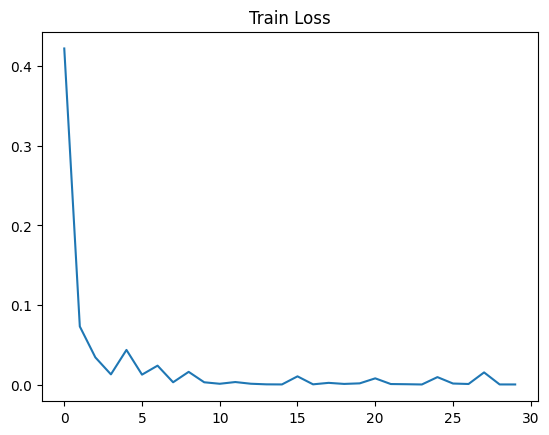

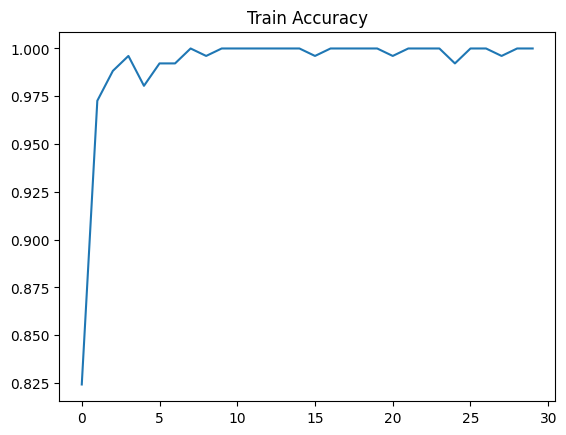

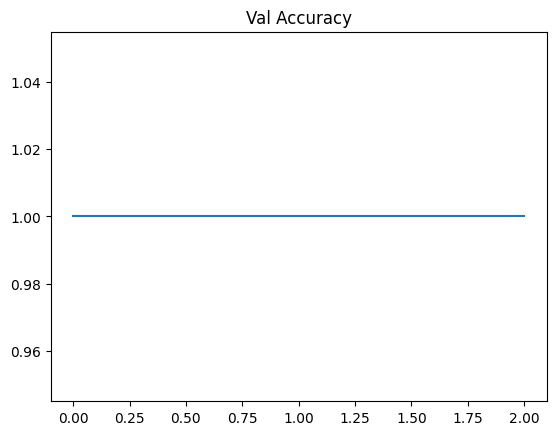

In [ ]:
# create an instance of the model
Bit_length = 8

model = Bit_wise_transformer(
      gpt2, 
      bitLength = Bit_length,
      input_dim = 2, 
      engine_embed_dim = 768,
).to(device)


# define the optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0
num_epochs = 3

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Training loop
    running_loss = 0.0
    data_iterator = tqdm(train_loader)
    for i, (inputs, labels) in enumerate(data_iterator):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 2), labels.view(-1))
        accuracy = torch.mean((torch.argmax(outputs, dim=-1).flatten() == labels.flatten()).float())
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())

        running_loss += loss.item()
        if (i + 1) % 50 == 0:
              #print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i * 50 + 1}/{len(train_loader)}], Loss: {running_loss / 50:.4f}')
            running_loss = 0.0
            losses.append(loss.item())
            train_acc.append(accuracy.item())
        
    # Validation
    val_acc = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device=device, dtype=torch.long)
          labels = labels.to(device=device, dtype=torch.long)
          outputs = model(inputs)
          accuracy = torch.mean((torch.argmax(outputs, dim=-1).flatten() == labels.flatten()).float())
          val_acc.append(accuracy.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))
    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)


plt.plot(losses)
plt.title('Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Val Accuracy')
torch.cuda.empty_cache()

some visualization of the attention matrix

In [ ]:
def visualize_bitxor_attn(model, input_bits, n_layer=0):
  model.output_attentions = True
  input_bits_t = torch.tensor(input_bits).type(torch.long)
  if len(input_bits_t.shape) < 2:
    input_bits_t = input_bits_t.unsqueeze(0)
  
  pred = model(input_bits_t.to(device))
  pred = torch.argmax(pred, dim=-1).squeeze(0).cpu().numpy()
  attentions = model.attn_output[n_layer].squeeze(0)  # first layer, first in batch
  mean_attentions = attentions.mean(dim=0)           # take the mean over heads
  mean_attentions = mean_attentions.detach().cpu().numpy()

  n_bit = int(input_bits_t.shape[-1]/2)
  plt.xlabel('Input Tokens', size=16)
  plt.xticks(range(n_bit * 2), input_bits)
  plt.ylabel('Output Tokens', size=16)
  plt.yticks(range(n_bit * 2), ['*'] * n_bit + list(pred))
  plt.title(f'attention map of layer {n_layer}')

  plt.imshow(mean_attentions)


correct out:  [1, 1, 1, 0, 0, 1, 1, 0]


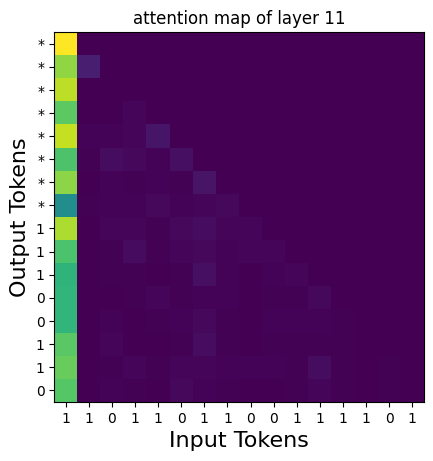

In [ ]:
input_bits = [
    1, 1, 0, 1, 1, 0, 1, 1,
    0, 0, 1, 1, 1, 1, 0, 1
]
ground_truth = [i ^ j for i, j in zip(input_bits[:8], input_bits[8:])]
print('correct out: ', ground_truth)
visualize_bitxor_attn(model, input_bits, n_layer=11)

Here, in the final plots of training and testing accuracy, you should see GPT-2 achieve a extremely good result.

#### Task 4: Bit Memory

In this part, we train on bit memory. In particular, this task is that we have 5 bit strings and have one of them being half masked. The model should judge what is the original bit string from the five.

Let's create dataset first. 

In [ ]:
class BitMemoryDataset(torch.utils.data.Dataset):
  def __init__(self,bit_length =1000, num_patterns=5, size = 100):
    self.bit_length = bit_length
    self.num_patterns = num_patterns
    self.size = size

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    bits = np.random.randint(low=0, high=2, size=(1, self.num_patterns, self.bit_length))
    bits = 2 * bits - 1
    query_inds = np.random.randint(low=0, high=self.num_patterns, size=1)
    query_bits = bits[range(1), query_inds]
    mask = np.random.randint(low=1, high=2, size=query_bits.shape)
    masked_query_bits = mask * query_bits
    masked_query_bits = masked_query_bits.reshape(1, 1, self.bit_length)
    x = np.concatenate([bits, masked_query_bits], axis=1)
    y = query_bits

    return torch.tensor(x, dtype=torch.float32).squeeze(), torch.tensor(y, dtype=torch.long).squeeze()



def generate_data_loaders(size = 100,bit_length = 1000, batch_size = 1, train_size=0.8):
  dataset = BitMemoryDataset(bit_length = bit_length, size=size)
  train_size = int(train_size * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

As before, load the pretrained model and freeze necessary part.

In [ ]:
# load the GP2 model
gpt2 = GPT2Model.from_pretrained('gpt2')

In [ ]:
# show the name of all the para your are able to modified in this model
for name, param in gpt2.named_parameters():
  print(name)

wte.weight
wpe.weight
h.0.ln_1.weight
h.0.ln_1.bias
h.0.attn.c_attn.weight
h.0.attn.c_attn.bias
h.0.attn.c_proj.weight
h.0.attn.c_proj.bias
h.0.ln_2.weight
h.0.ln_2.bias
h.0.mlp.c_fc.weight
h.0.mlp.c_fc.bias
h.0.mlp.c_proj.weight
h.0.mlp.c_proj.bias
h.1.ln_1.weight
h.1.ln_1.bias
h.1.attn.c_attn.weight
h.1.attn.c_attn.bias
h.1.attn.c_proj.weight
h.1.attn.c_proj.bias
h.1.ln_2.weight
h.1.ln_2.bias
h.1.mlp.c_fc.weight
h.1.mlp.c_fc.bias
h.1.mlp.c_proj.weight
h.1.mlp.c_proj.bias
h.2.ln_1.weight
h.2.ln_1.bias
h.2.attn.c_attn.weight
h.2.attn.c_attn.bias
h.2.attn.c_proj.weight
h.2.attn.c_proj.bias
h.2.ln_2.weight
h.2.ln_2.bias
h.2.mlp.c_fc.weight
h.2.mlp.c_fc.bias
h.2.mlp.c_proj.weight
h.2.mlp.c_proj.bias
h.3.ln_1.weight
h.3.ln_1.bias
h.3.attn.c_attn.weight
h.3.attn.c_attn.bias
h.3.attn.c_proj.weight
h.3.attn.c_proj.bias
h.3.ln_2.weight
h.3.ln_2.bias
h.3.mlp.c_fc.weight
h.3.mlp.c_fc.bias
h.3.mlp.c_proj.weight
h.3.mlp.c_proj.bias
h.4.ln_1.weight
h.4.ln_1.bias
h.4.attn.c_attn.weight
h.4.attn.c_at

In [ ]:
for name, param in gpt2.named_parameters():
# freeze all parameters except the layernorm and positional embeddings 
  if 'ln' in name or 'wpe' in name:
    param.requires_grad = True 
  else:
    param.requires_grad = False

Design and train your own network using pretrained GPT2 model as universal computational engine. You need to design

*   An input embedding layer, which projects your input to accommodate GPT2 input demension

*   An output Linear layer and loss function

In [ ]:
class Bit_Memory_transformer(nn.Module):
  def __init__(self, engine,input_dim, engine_embed_dim, n_class, patch_size):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = n_class
    self.input_embed = nn.Linear(input_dim, engine_embed_dim)
    self.engine = engine
    self.output_layer = nn.Linear(engine_embed_dim, n_class)
  def forward(self, x):
        orig_dim = x.shape[-1]
        ratio = orig_dim // self.input_dim
        x = x.reshape(x.shape[0], x.shape[1] * ratio, self.input_dim)
        flattened_input = x.view(-1, 50)

        x = self.input_embed(flattened_input)
        
        x = self.engine(inputs_embeds = x.unsqueeze(0)).last_hidden_state
        x = x[:,-ratio:]
        x = self.output_layer(x)

        x = x.reshape(x.shape[0], x.shape[1] // ratio, ratio * self.output_dim)
        return x
        

    

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()
def loss_fn(out, y, x=None, bit_length = 1000):
  out = torch.reshape(out, (-1, bit_length, 2))
  ids = torch.zeros(y.shape).to(device=y.device).long()
  ids[y < 0], ids[y > 0] = 0, 1
  out, ids = torch.reshape(out, (-1, 2)), torch.reshape(ids, (-1,))
  return ce_loss(out, ids)

def accuracy_fn(preds, true, x=None, bit_length = 1000):
        preds = preds.reshape(-1, bit_length, 2).argmax(-1) * 2 - 1
        return (np.sign(preds) == np.sign(true)).mean()

def get_loss(x,y,bit_length ,return_acc = True):
  out = model(x)
  loss = loss_fn(out, y, x=x, bit_length = bit_length)
  accs = accuracy_fn(
                out.detach().cpu().numpy(),
                y.detach().cpu().numpy(),
                x=x.detach().cpu().numpy(),
                bit_length = bit_length
            )
  return loss, accs

In [ ]:
model = Bit_Memory_transformer(
    gpt2, 
    input_dim = 50, 
    engine_embed_dim = 768,
    n_class= 2*50,
    patch_size = 50
)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Val Accuracy')

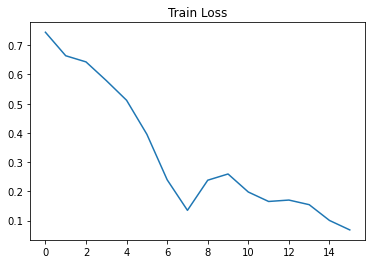

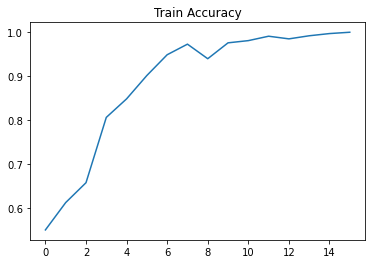

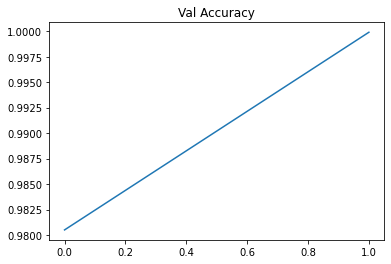

In [ ]:
bit_length = 1000
data_size = 100

train_loader, test_loader = generate_data_loaders(bit_length = bit_length, size = data_size, batch_size=1, train_size=0.8)

# define the optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0
num_epochs = 2

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Training loop
    data_iterator = tqdm(train_loader)
    for i, (inputs, labels) in enumerate(data_iterator):
      loss, acc = get_loss(inputs, labels,bit_length, return_acc=True)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      data_iterator.set_postfix(loss=loss.item())

      if (i + 1) % 10 == 0:
            losses.append(loss.item())
            train_acc.append(acc.item())

    # validation loop
    val_acc = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in test_loader:
        loss, acc = get_loss(inputs, labels,bit_length, return_acc=True)
        val_acc.append(acc.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))
    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Val Accuracy')

#### Task 3: Image classfication

For sure the last task is quite simple and may not so convincing to show the generality of GPT-2. Now we move to a more complex domain, image classfication. We will do the task on the famous hand-written dataset MNIST and reach a good result

Still, we need to freeze some parameters in GPT-2 first.

In [ ]:
# A function freeze necessary parameters in GPT-2
def gpt2_freezer(
    model,                         
    freeze_param_list: List[str] = None
):
  for (name, param) in model.named_parameters():
    if freeze_param_list is not None:
      if any([k in name for k in freeze_param_list]):
        param.requires_grad = False
    else:
      param.requires_grad = False
  return model

In [ ]:
pretrained_gpt2 = GPT2Model.from_pretrained('gpt2') 
gpt2_engine = gpt2_freezer(
    pretrained_gpt2,
    freeze_param_list = ["mlp", "attn"]
  )

Then, since the image is too large for to input, we need to patchify the image

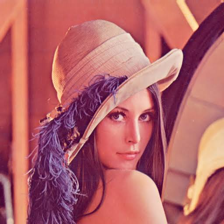

In [ ]:
def tensor2PIL(tensor: torch.Tensor):
    return transforms.ToPILImage()(tensor)

def display_patches(
    patches: torch.Tensor,
    n_patch: int
):
    
    fig, axes = plt.subplots(n_patch, n_patch)
    for i in range(n_patch):
        for j in range(n_patch):
            patch = patches[i*n_patch + j,:]
            axes[i][j].imshow(tensor2PIL(patch))
            axes[i][j].axis('off')
            
    plt.show()


def patchify(
    img: torch.Tensor,
    n_patch: int) -> torch.Tensor:
    
    b, c, h, w = img.shape
    patch_h = h // n_patch
    patch_w = w // n_patch
    patches = img.unfold(-1, patch_h, patch_h) \
                 .permute(0, 3, 1, 4, 2) \
                 .unfold(-1, patch_w, patch_w) \
                 .permute(0, 4, 1, 2, 5, 3)
    patches = torch.reshape(patches, (b, n_patch * n_patch, c, patch_h, patch_w,))
                 
    
    return patches
lenna = "https://i.stack.imgur.com/XKUT9.png"
img = Image.open(requests.get(lenna, stream=True).raw).resize((224, 224))
img

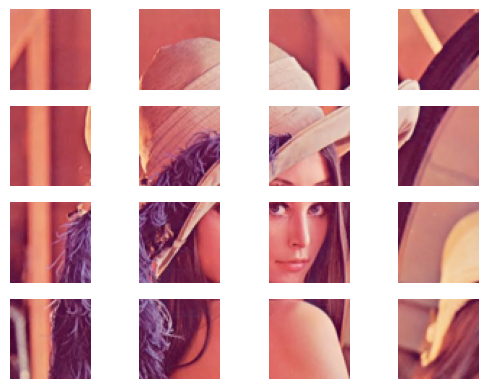

In [ ]:
# test if patchfy works correctly

transform = transforms.PILToTensor()
img = transform(img)
patches = patchify(img.unsqueeze(0), 4)
display_patches(patches[0], 4)

Here, some prepocessing

In [ ]:
img_size = (28, 28)
batch_size = 32
transform = transforms.Compose([
      transforms.Resize(img_size),
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])
dataset = torchvision.datasets.MNIST('./data', train=True, download=True,
                    transform=transform)

train_val_split = 0.8
train_size = int(train_val_split * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


test_dataset = torchvision.datasets.MNIST('./data', train=False,
                      transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Now, it is time to design and train your own network using pretrained GPT2 model as main computational engine. You need to design
  * An input embedding layer, which projects your input to accommodate GPT2 input dimension
  * An output Linear layer and loss function

In [ ]:
class MNIST_clf(nn.Module):
  def __init__(self, engine, n_patch, input_dim, engine_embed_dim, n_class=10):
    super().__init__()
    self.n_patch = n_patch
    self.input_flatten = nn.Flatten(start_dim=-3, end_dim=-1)
    self.input_embed = nn.Linear(input_dim, engine_embed_dim)
    self.cls_token = nn.Parameter(torch.randn(1, 1, engine_embed_dim) * 0.02)
    self.engine = engine
    self.out = nn.Linear(engine_embed_dim, n_class)
    self.attn_output = None
  def forward(self, x, output_attentions=False):
    x = patchify(x, self.n_patch)
    embeds = F.relu(
        self.input_embed(self.input_flatten(x))
    )
    # embeds = torch.concat([embeds, self.cls_token.repeat(B, 1, 1)], dim=-2)

    gpt2_output = self.engine(inputs_embeds=embeds, output_attentions=output_attentions)
    output = self.out(gpt2_output.last_hidden_state[:,-1])
    if output_attentions:
      self.attn_output = gpt2_output.attentions
    return output

To help you better understand what happens in attention layer, here are some visualization functions.

In [ ]:
def MNIST_unnormalize(x):
  return (x * 0.3081 + 0.1307) * 255


def logits_with_temp(logits, temp=0.2):
  logits = torch.exp(logits/temp)
  logits = logits / torch.sum(logits)
  return logits

def visualize_attn_on_image(img, model, mode='last_embed'):
  '''
      Input: 
        img   -> normalized img
        model -> transformer model to obtain attention map for each layer
  '''
  # nifty way to check whether model is on cuda
  img = img.to(next(model.parameters()).device)

  with torch.no_grad():
    model(img.unsqueeze(0), output_attentions=True)
    attentions = model.attn_output
  
  attentions = torch.stack([attn.squeeze(0).mean(dim=0) for attn in attentions], dim=0).cpu()

  # accounting for residual connnection, then renormalize attention
  augmented_attn = attentions + torch.eye(attentions.shape[-1])
  augmented_attn = augmented_attn / augmented_attn.sum(dim=-1).unsqueeze(-1)

  # rolled_out_attn = torch.eye(augmented_attn.shape[-1])
  # for layer_idx in range(augmented_attn.shape[0]):
  #   rolled_out_attn = augmented_attn[layer_idx] @ rolled_out_attn

  mask = logits_with_temp(augmented_attn[-1,-1], 0.3) \
         .reshape(4, -1)

  mask = np.ascontiguousarray(
      (mask/mask.max()).detach().numpy()
  )
  mask = cv2.resize(mask, (28, 28))

  img = MNIST_unnormalize(
      img.squeeze(0).cpu().detach().numpy()
  )
  return (img * mask).astype('uint8')

def display_MNIST_with_attn(img_batch, model, img_size=(16,16)):
  n = img_batch.shape[0]
  fig, axs = plt.subplots(nrows=n, ncols=2, figsize=img_size)

  axs[0, 0].set_title('Original')
  axs[0, 1].set_title('Attention Map')
  for i, img in enumerate(img_batch):

    attn_map = visualize_attn_on_image(
        img, 
        model
    )
    img = MNIST_unnormalize(img).squeeze(0).cpu().numpy().astype('uint8')

    axs[i, 0].imshow(img)
    axs[i, 1].imshow(attn_map)
  fig.tight_layout()


In [ ]:
torch.cuda.is_available()

True

First, we check how's the prediction result before training

In [ ]:
assert torch.cuda.is_available()
device = torch.device('cuda')
model = MNIST_clf(
    gpt2_engine, 
    n_patch = 4,
    input_dim = 49, 
    engine_embed_dim = 768
).to(device)

model = model.to(device)

acc = 0
model.eval()
for i, data in enumerate(test_dataloader):
  inputs, labels = data
  inputs = inputs.to(device); labels = labels.to(device)
  with torch.no_grad():
    pred = model(inputs).argmax(-1)
    acc += sum(pred == labels)

print("Accuracy: {:.2f}%".format(100 * acc/len(test_dataloader.dataset)))

Accuracy: 10.49%


Then, treat the GPT2 as a main computation engine and do the training

In [ ]:
assert torch.cuda.is_available()
device = torch.device("cuda")

n_epoch = 3

model = MNIST_clf(
    gpt2_engine, 
    n_patch = 4,
    input_dim = 49, 
    engine_embed_dim = 768
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
best_val_acc = .0

epoch_iterator = trange(n_epoch)
for epoch in epoch_iterator:  
    data_iterator = tqdm(train_dataloader)

    # running_loss = 0.0

    # training loop
    model.train()
    for i, data in enumerate(data_iterator):
        inputs, labels = data
        inputs = inputs.to(device); labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())
    
    # validation loop
    acc = 0
    model.eval()
    for data in val_dataloader:
      inputs, labels = data
      inputs = inputs.to(device); labels = labels.to(device)
      with torch.no_grad():
        pred = model(inputs).argmax(-1)
        acc += sum(pred == labels).detach().cpu()
    val_acc = acc / len(val_dataloader.dataset)
    
    if val_acc > best_val_acc:
      best_val_acc = val_acc
    
    epoch_iterator.set_postfix(val_acc = val_acc, best_val_acc = best_val_acc)



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Test how the model perform on test set, you should see it reaches an accuracy about 80%.

In [ ]:
# Test performance of model
acc = 0
model.eval()
for i, data in enumerate(test_dataloader):
  inputs, labels = data
  inputs = inputs.to(device); labels = labels.to(device)
  with torch.no_grad():
    pred = model(inputs).argmax(-1)
    acc += sum(pred == labels)

print("Accuracy: {:.2f}%".format(100 * acc/len(test_dataloader.dataset)))  # 90


Accuracy: 92.21%


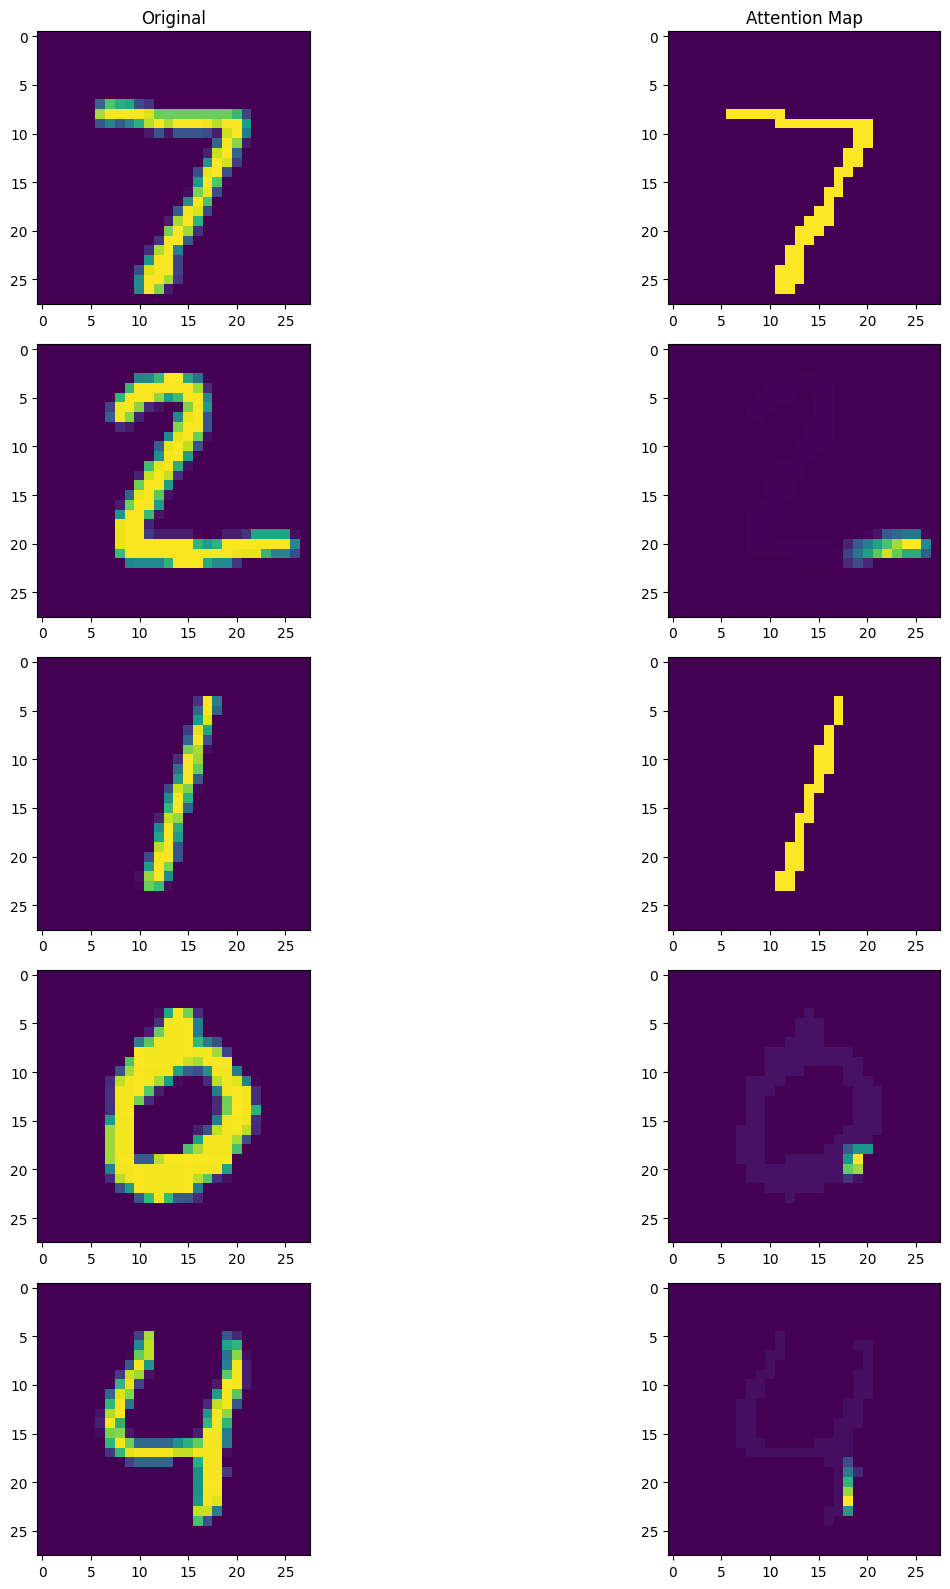

In [ ]:
batch_x, batch_y = next(iter(test_dataloader))
display_MNIST_with_attn(batch_x[:5], model)

### **Advantages of Pre-trained Models: Speed and Accuracy**

In previous part, you have seen the power of using GPT-2 pretrained on language tasks can do visual task as well.
In this part, you are going to train/finetune a ResNet-50 and compare it with GPT-2

In [ ]:
from torch.utils.data import DataLoader
# Rescale MNIST and make it 3 channel
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define dataloaders
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Like GPT-2, we use pretrained 

In [ ]:
# Frozen, only train the last layer
res50_frozen = torchvision.models.resnet50(pretrained=True)
for param in res50_frozen.parameters():
    param.requires_grad = False
num_ftrs = res50_frozen.fc.in_features
res50_frozen.fc = nn.Linear(num_ftrs, 10)
res50_frozen.fc.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res50_frozen.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, res50_frozen.parameters()), lr=0.001, momentum=0.9)

# Train the model for 10 epochs
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader)):
        inputs, labels = data[0].to(device), data[1].to(device) # Move the data to the specified CUDA device
        optimizer.zero_grad()
        outputs = res50_frozen(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

print('Done')

# eval
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move the data to the specified CUDA device
        outputs = res50_frozen(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total)) # 99%


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Done
Accuracy on test set: 92 %


Here, we check the trainable parameter numbers of frozen resnet 50 and frozen GPT-2

In [ ]:
def get_parameter_number(model):
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}
print(get_parameter_number(res50_frozen))
print(get_parameter_number(model))

{'Total': 23528522, 'Trainable': 20490}
{'Total': 124486666, 'Trainable': 39469066}


### **Influence of Model Capacity on Accuracy and Training Time**

In this section, we study how to model size will influence the accuracy and training time. We use small, medium and large GPT-2 for comparision. The training task is the bitwise operator you designed before.

In the tranning function below, we use the parameter `engine_name` to select different size model.

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import gc


def train(engine_name, train_loader, test_loader, Bit_length, num_epochs = 2):

  # create an instance of the model
  gpt2_engine = GPT2Model.from_pretrained(engine_name)
  for name, param in gpt2_engine.named_parameters():
    # freeze all parameters except the layernorm and positional embeddings 
    if 'ln' in name or 'wpe' in name:
      param.requires_grad = True 
    else:
      param.requires_grad = False


  # Choose the correct embedding size based on the GPT-2 model
  if engine_name == "gpt2":
      engine_embed_dim = 768
  elif engine_name == "gpt2-medium":
      engine_embed_dim = 1024
  elif engine_name == "gpt2-large":
      engine_embed_dim = 1280
  elif engine_name == "gpt2-xl":
      engine_embed_dim = 1600
  else:
      raise ValueError(f"Invalid model name: {engine_name}")

  model = Bit_wise_transformer(
      gpt2_engine, 
      bitLength = Bit_length,
      input_dim = 2, 
      engine_embed_dim = engine_embed_dim
  ).to(device)

  # define the optimizer and loss
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  losses = []
  train_acc = []
  all_val_acc = []
  best_val_acc = 0

  epoch_iterator = trange(num_epochs)
  for epoch in epoch_iterator:
      # Training loop
      running_loss = 0.0
      data_iterator = tqdm(train_loader)
      for i, (inputs, labels) in enumerate(data_iterator):
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs.view(-1, 2), labels.view(-1))
          accuracy = torch.mean((torch.argmax(outputs, dim=-1).flatten() == labels.flatten()).float())
          loss.backward()
          optimizer.step()

          data_iterator.set_postfix(loss=loss.item())

          running_loss += loss.item()
          if (i + 1) % 50 == 0:
                #print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i * 50 + 1}/{len(train_loader)}], Loss: {running_loss / 50:.4f}')
              running_loss = 0.0
              losses.append(loss.item())
              train_acc.append(accuracy.item())
          
      # Validation
      val_acc = []
      model.eval()
      with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device=device, dtype=torch.long)
            labels = labels.to(device=device, dtype=torch.long)
            outputs = model(inputs)
            accuracy = torch.mean((torch.argmax(outputs, dim=-1).flatten() == labels.flatten()).float())
            val_acc.append(accuracy.item())
      model.train()

      all_val_acc.append(np.mean(val_acc))
      # Save best model
      if np.mean(val_acc) > best_val_acc:
          best_val_acc = np.mean(val_acc)

      epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

  del model
  gc.collect()
  torch.cuda.empty_cache()
  return best_val_acc

Here, we train with different model size and how accuracy changed with the size.

In [ ]:
engine_list = ["gpt2","gpt2-medium","gpt2-large"]
# engine_list = ["gpt2-large"]

In [ ]:
# train the modified model
Bit_length = 8
Data_size = 20000

# training the model
train_loader, test_loader = generate_data_loaders(n=Bit_length, batch_size=32,data_size = Data_size, train_size=0.7)

results = []

for engine_name in engine_list:
  print("We are training the model engine: ", engine_name)
  start_time = time.time()
  best_val_acc = train(engine_name, train_loader, test_loader, Bit_length, num_epochs = 1)
  train_time = time.time() - start_time
  #print("The best val accuracy using the model engine -- ", engine_name, ": ", best_val_acc)

  results.append({
        "model": engine_name,
        "val_accuracy": best_val_acc,
        "train_time": train_time
    })


We are training the model engine:  gpt2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

We are training the model engine:  gpt2-medium


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

In [ ]:
# Print the results
for result in results:
    print(f"Model: {result['model']}")
    print(f"Accuracy: {result['val_accuracy']}")
    print(f"Training Time: {result['train_time']} seconds")
    print()

Model: gpt2
Accuracy: 0.711415392287234
Training Time: 41.598315954208374 seconds

Model: gpt2-medium
Accuracy: 0.7546750332446809
Training Time: 128.36421084403992 seconds

Model: gpt2-large
Accuracy: 0.7877534906914894
Training Time: 255.6324303150177 seconds



Results Table:


,model,val_accuracy,train_time
0,gpt2,0.711415,41.598316
1,gpt2-medium,0.754675,128.364211
2,gpt2-large,0.787753,255.632430


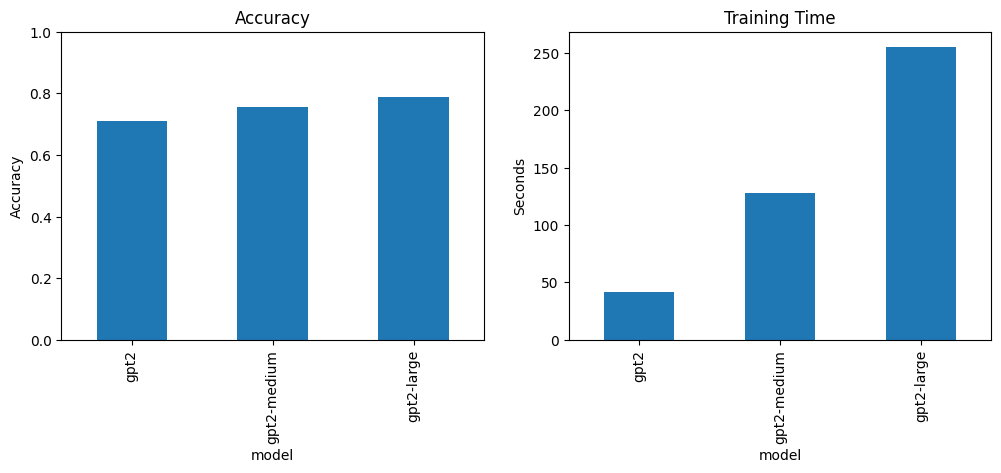

In [ ]:
# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results in a table
print("Results Table:")
display(results_df)

# Plot accuracy and F1 score
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

results_df.plot(x="model", y="val_accuracy", kind="bar", ax=ax[0], legend=False)
ax[0].set_title("Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(0, 1)

results_df.plot(x="model", y="train_time", kind="bar", ax=ax[1], legend=False)
ax[1].set_title("Training Time")
ax[1].set_ylabel("Seconds")

plt.show()


### **Interpreting Attention Layers in GPT-2**